A very simple __Recurrent Neural Network__ tutorial.
In particular, a *very simple* __LSTM__ implementation tutorial using __TensorFlow__ library.
We demonstrate sequence recognition problem with 1-dimensional data (square-wave vs sine-wave)

The goals of this tutorial are:
* To keep code as simple as possible, so that its useful for beginners in Tensorflow/RNN
* To focus on the basic ideas, and not necessarily the best practices in coding
* No dependency on any external data source, this tutorial generates the data for you
* To help developers apply some of the ideas presented here, to their own real-world applications

Author: Chandan Gope

Apologies in advance for not providing detailed comments. But I hope the code is self-explanatory, given that I have tried to keep it very simple.
Feel free to test it with various parameter configurations and see what it does. But I myself have not tested it beyond what I present. If the code breaks, feel free to fix it and learn in the process!

In [10]:
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf

### Lets start with some numpy stuff, no Tensorflow yet!

Lets configure some parameters related to our data (square-waveforms and sine-waveforms with noise)

In [11]:
sequence_length = 16    #how many time-steps in my RNN
input_dimension = 1     #our data is just 1-dimensional, just a sequence of scalars
num_classes = 2         #our classes are - 'square-wave' and 'sine-wave'
noise_stdev = 0.2       # stdev of noise we want to add to the waveforms

Lets generate square and sine waveforms, with noise added. Everytime the function is called, it creates random realizations of square-waveforms and sine-waveforms. Each waveform will consist of a sequence of 'sequence_length' scalars. Remember, our data is 1-D.
* Pardon some of the hard-coded values below, but you get the idea...

In [12]:
def generateWaveforms(noise_stdev=0.0):
    num_points = np.random.randint(36, 48) #at least 36, and less than 48
    noise = np.random.normal(0, noise_stdev, num_points)
    t = np.linspace(0, 1, num_points, endpoint=False)
    sq = signal.square(2 * np.pi * 5 * t) + noise
    si = np.sin(2 * np.pi * 5 * t) + noise

    #select a subset of consecutive points, with a random starting point
    subset_points = sequence_length #should be less than 36
    start_index = np.random.randint(0, 36-subset_points)
    sq_subset = sq[start_index:start_index+subset_points]
    t_sq_subset = t[start_index:start_index+subset_points]

    start_index = np.random.randint(0, 36-subset_points)
    si_subset = si[start_index:start_index+subset_points]
    t_si_subset = t[start_index:start_index+subset_points]
    
    return (sq_subset, si_subset)

Generate a batch of waveforms data, consisting of equal numbers of square-waveforms and sine-waveforms

In [13]:
def generateBatch(noise_stdev, batch_size=2):
    #we have 2 classes (square=1, sine=0), and half of the batch will be square-waves and other half will be sine-waves
    batch_size_per_class = batch_size/2
    X = np.empty((0, sequence_length, input_dimension))
    Y = np.empty((0, 2))
    for r in range(int(batch_size_per_class)):
        sq, si = generateWaveforms(noise_stdev)
        X = np.append(X, [sq[:,np.newaxis]], axis=0)
        Y = np.append(Y, [np.array([1,0])], axis=0)
        
        X = np.append(X, [si[:,np.newaxis]], axis=0)
        Y = np.append(Y, [np.array([0,1])], axis=0)
    
    return X, Y

Below we just do some visualizations to understand what our data looks like

Type of X: <class 'numpy.ndarray'>
Shape of X (batch_size, sequence_length, input_dimension) = (12, 16, 1)
Type of y: <class 'numpy.ndarray'>
Shape of y (batch_size, num_classes) = (12, 2)


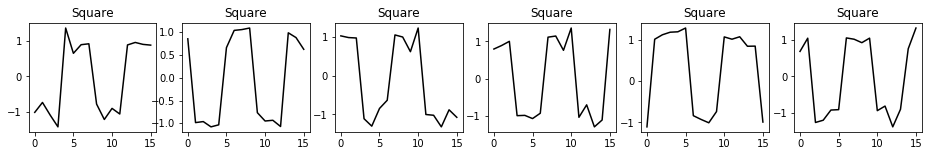

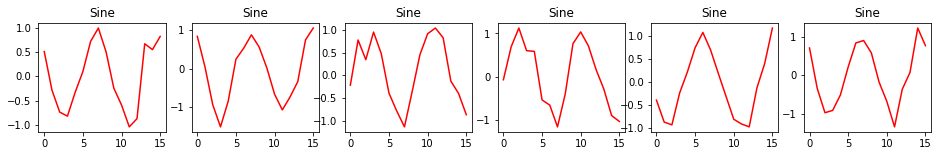

In [14]:
batch_size = 12 #keep it as a multiple of 2, so we can divide it equally by 2

X, y = generateBatch(noise_stdev, batch_size)

#Print the type and shapes of the arrays
print("Type of X: {0}".format(type(X)))
print("Shape of X (batch_size, sequence_length, input_dimension) = {0}".format(X.shape))
print("Type of y: {0}".format(type(y)))
print("Shape of y (batch_size, num_classes) = {0}".format(y.shape))

#Now lets plot them, to see what they look like
fig_square=plt.figure(figsize=(16,2))
fig_sine=plt.figure(figsize=(16,2))
index_square = 0
index_sine = 0
for r in range(batch_size):
    is_square = y[r,0]==1
    data = X[r,].flatten()
    if(is_square):
        index_square += 1
        ax=fig_square.add_subplot(1,int(batch_size/2),index_square)
        ax.plot(data, 'k')
        ax.set_title('Square')
    else:
        index_sine += 1
        ax=fig_sine.add_subplot(1,int(batch_size/2),index_sine)
        ax.plot(data, 'r')
        ax.set_title('Sine')
    

Note that the waveforms also have random phase-shifts, to make the data more real-world. But our window of analysis will always be a window of length 'sequence_length'

Notice that with noise_stdev = 0.3, it starts becoming hard to visually tell apart the square-wave from sine-wave. In your experiments, try with 
* noise_stdev < 0.3 => the RNN should be able to do a good job in learning
* noise_stdev >> 0.3 => the RNN should NOT be able to do a good job in learning

### Now lets do the Tensorflow stuff

Function to compute the outputs of my RNN, given the input data. Note that RNN will give you a sequence of outputs, and in many applications (such as language modeling) the entire output sequence will be used. Here, for our classification problem we are only interested in the last output of the sequence.

In [15]:
def runRNN(X, weights, biases):
    # Our X has shape: (batch_size, sequence_length, input_dimension)
    # TF wants: a list of 'sequence_length' tensors, each of shape (batch_size, input_dimension)
    # We will use unstack to get a list of 'sequence_length' tensors, each of shape (batch_size, input_dimension)
    X = tf.unstack(X, sequence_length, 1)

    cell = tf.contrib.rnn.BasicLSTMCell(hidden_nodes)

    # Get outputs (dont care about states)
    outputs, states = tf.contrib.rnn.static_rnn(cell, X, dtype=tf.float32)

    # We just care about the last output in the list
    return tf.matmul(outputs[-1], W['out']) + b['out']

In [17]:
# Construct the computational graph.
tf.reset_default_graph()
X = tf.placeholder("float", [None, sequence_length, input_dimension]) #Batch-size x 16 x 1
Y = tf.placeholder("float", [None, num_classes]) # Batch-size x 2

hidden_nodes = 64 # number of nodes 

W = {
    'out': tf.Variable(tf.random_normal([hidden_nodes, num_classes]))
}
b = {
    'out': tf.Variable(tf.random_normal([num_classes]))
}

batch_size = 64 #keep it as a multiple of 2
learning_rate = 0.001
training_steps = 20000
display_step = 1000
noise_stdev = 0.20       # stdev of noise we want to add to the waveforms

#ops for training
logits = runRNN(X, W, b)
prediction = tf.nn.softmax(logits)
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

#ops for computing accuracy
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# init op
init = tf.global_variables_initializer()

with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, training_steps+1):
        batch_x, batch_y = generateBatch(noise_stdev, batch_size)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate loss and accuracy for the batch
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x, Y: batch_y})
            print("Step " + str(step) + ", Loss= " + "{:.3f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("{0} training steps completed".format(training_steps))
    
    #Now check accuracy on some test data, with a higher noise than that in training
    noise_stdev = 0.30
    batch_size = 1000
    test_x, test_y = generateBatch(noise_stdev, batch_size)
    test_acc = sess.run(accuracy, feed_dict={X: test_x, Y: test_y})
    print("\nTesting Accuracy on {0} samples: {1}".format(batch_size, test_acc) )
    
    

Step 1, Loss= 0.817, Training Accuracy= 0.500
Step 1000, Loss= 0.679, Training Accuracy= 0.656
Step 2000, Loss= 0.656, Training Accuracy= 0.719
Step 3000, Loss= 0.622, Training Accuracy= 0.859
Step 4000, Loss= 0.558, Training Accuracy= 0.938
Step 5000, Loss= 0.293, Training Accuracy= 0.984
Step 6000, Loss= 0.069, Training Accuracy= 1.000
Step 7000, Loss= 0.028, Training Accuracy= 1.000
Step 8000, Loss= 0.011, Training Accuracy= 1.000
Step 9000, Loss= 0.042, Training Accuracy= 1.000
Step 10000, Loss= 0.006, Training Accuracy= 1.000
Step 11000, Loss= 0.018, Training Accuracy= 1.000
Step 12000, Loss= 0.021, Training Accuracy= 1.000
Step 13000, Loss= 0.024, Training Accuracy= 1.000
Step 14000, Loss= 0.033, Training Accuracy= 0.984
Step 15000, Loss= 0.004, Training Accuracy= 1.000
Step 16000, Loss= 0.012, Training Accuracy= 1.000
Step 17000, Loss= 0.004, Training Accuracy= 1.000
Step 18000, Loss= 0.005, Training Accuracy= 1.000
Step 19000, Loss= 0.007, Training Accuracy= 1.000
Step 20000, L